In [93]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import ParameterSampler, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

rng = np.random.default_rng(2005)

# 1. Изучить принципы работы RBF-сетей, их преимущества и недостатки.

In [94]:
df = pd.read_csv('datasets/csgo_games.csv')

In [95]:
df.shape

(3787, 170)

In [96]:
df.head()

,match_date,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,...,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc
0,2016-12-18,CLOUD9,HELLRAISERS,13,16,9,20,0.500000,0.500000,t2,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667
1,2016-12-18,IMMORTALS,G2,17,19,13,10,0.500000,0.500000,t2,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
2,2016-12-18,MOUSESPORTS,IMMORTALS,16,3,12,13,0.500000,0.500000,t1,...,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,False,0.733333
3,2016-12-18,DIGNITAS,G2,16,9,6,10,0.416667,0.583333,t1,...,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
4,2016-12-18,OPTIC,HELLRAISERS,16,10,4,20,0.500000,0.500000,t1,...,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667


### Параметры статистики команды и игроков (hltv.org)

- **Мировой рейтинг:**  
  Мировой рейтинг команды на дату матча согласно рейтингу hltv.org.

- **Очков:**  
  Количество набранных очков. Может быть меньше 5, если матч проходил в формате best of five.  
  *Пример:* Если `t1_points = 3` и `t2_points = 2`, то команда t1 выиграла противостояние.

- **H2H Win Perc:**  
  Плавающее значение от 0 до 1, представляющее долю побед в прошлых матчах против другой команды.  
  Будет равно 0.5, если предыдущих противостояний не было.

---

### Характеристики игроков (player1 - player5)

Игроки упорядочены от 1 до 5 в соответствии с их рейтингом на hltv.org (игрок с лучшим рейтингом всегда будет считаться player1). Все характеристики игроков рассчитываются за три месяца до даты матча и предоставляются hltv.org.

- **Рейтинг:**  
  Основная метрика качества игрока.

- **Влияние:**  
  Общее влияние игрока на игру (обычно коррелирует с важными и решающими убийствами).

- **KDR:**  
  Соотношение общего количества убийств к общему количеству смертей.

- **DMR:**  
  Средний урон за раунд.

- **KPR:**  
  Среднее количество убийств за раунд.

- **APR:**  
  Среднее количество ассистов на убийства товарищей по команде за раунд.

- **DPR:**  
  Среднее количество смертей за раунд.

- **SPR:**  
  Среднее количество спасенных соратников за раунд.

- **OPK Ratio:**  
  Соотношение общего количества убийств в начале раунда к общему количеству смертей в начале раунда.

- **OPK Rating:**  
  Оценка игрока hltv в начале раунда.

- **Wins Perc After FK:**  
  Конверсия раунда, когда игрок получает первое убийство в раунде.

- **FK Perc in Wins:**  
  Доля раундов, в которых первое убийство принадлежало игроку в выигранных раундах.

- **Multikill Perc:**  
  Доля раундов, в которых игрок совершил два и более убийств.

- **Рейтинг не менее одного Perc:**  
  Доля сыгранных матчей, в которых игрок имел рейтинг не менее 1.0.

- **Является снайпером:**  
  Булево значение, указывающее, является ли у игрока оружие "AWP" (снайпер) первым или вторым по количеству убийств.

- **Clutch Win Perc:**  
  Коэффициент конверсии игрока в ситуациях один против одного.


In [97]:
df.info(memory_usage='deep')

na_counts = df.isna().sum()
print('\nПропущенные значения:')
display(na_counts[na_counts > 0].sort_values(ascending=False))

dup_cnt = df.duplicated().sum()
print(f'\nДубликаты: {dup_cnt}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3787 entries, 0 to 3786
Columns: 170 entries, match_date to t2_player5_clutch_win_perc
dtypes: bool(10), float64(152), int64(4), object(4)
memory usage: 5.5 MB

Пропущенные значения:


t1_player5_wins_perc_after_fk    2
t2_player3_wins_perc_after_fk    1
t2_player5_wins_perc_after_fk    1
dtype: int64


Дубликаты: 0


In [98]:
df['match_date'] = pd.to_datetime(df['match_date'], errors='coerce')

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

df.dropna(axis=0, subset=['team_1', 'team_2', 'winner'], inplace=True)


df = df.drop_duplicates().reset_index(drop=True)

na_counts = df.isna().sum()
display(na_counts[na_counts > 0].sort_values(ascending=False))

Series([], dtype: int64)

In [99]:
df['winner'] = df['winner'].map({'t1': 0, 't2': 1})

df = df.dropna(subset=['winner']).astype({'winner': 'int8'})

teams_ohe = pd.get_dummies(df[['team_1', 'team_2']],
                           prefix=['team_1', 'team_2'],
                           dtype="int8")
df = pd.concat([df.drop(['team_1', 'team_2'], axis=1), teams_ohe], axis=1)

print(f'Итоговая размерность: {df.shape}')

Итоговая размерность: (3763, 298)


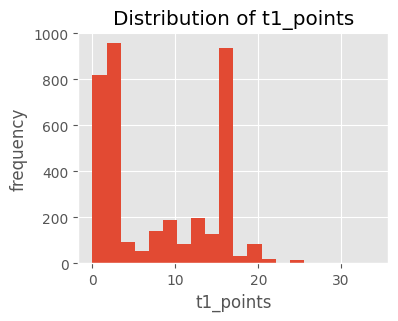

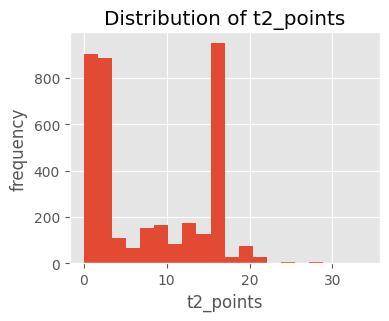

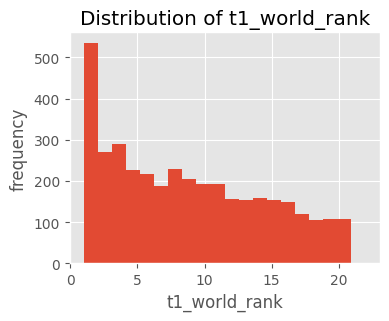

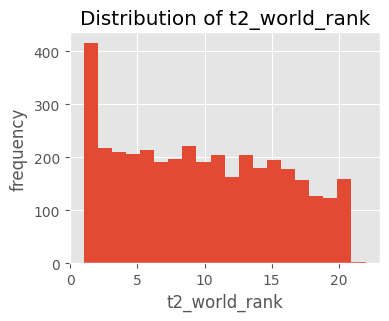

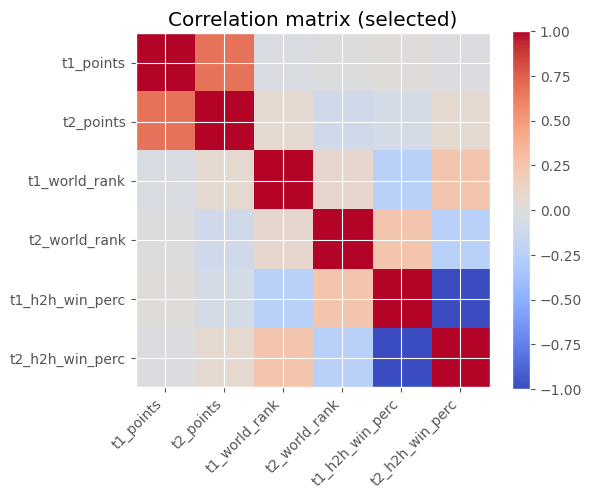

In [100]:
plt.style.use('ggplot')
important_feats = ['t1_points', 't2_points',
                   't1_world_rank', 't2_world_rank',
                   't1_h2h_win_perc', 't2_h2h_win_perc']

for feat in important_feats[:4]:
    df[feat].hist(bins=20, figsize=(4,3))
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('frequency')
    plt.show()

corr_feats = important_feats
corr = df[corr_feats].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(corr_feats)), corr_feats, rotation=45, ha='right')
plt.yticks(range(len(corr_feats)), corr_feats)
plt.title('Correlation matrix (selected)')
plt.colorbar()
plt.tight_layout()
plt.show()

In [101]:
y = df['winner']
X = df.drop('winner', axis=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=2005,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.17647,       
    random_state=2005,
    stratify=y_train_val
)

print(f'Train:      {X_train.shape[0]} rows')
print(f'Validation: {X_val.shape[0]} rows')
print(f'Test:       {X_test.shape[0]} rows')


Train:      2633 rows
Validation: 565 rows
Test:       565 rows


# 2. Применить RBF-сети для решения задачи классификации или регрессии на датасете "CS:GO
Professional Matches".

In [102]:
def to_tensor(arr, device='cpu', ensure_2d=True):
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy(dtype=np.float32)
    else:
        arr = np.asarray(arr, dtype=np.float32)
    if ensure_2d and arr.ndim == 1:
        arr = arr[:, None]
    return torch.from_numpy(arr).to(device)

X_train_t = to_tensor(X_train)
y_train_t = to_tensor(y_train)

X_val_t   = to_tensor(X_val)
y_val_t   = to_tensor(y_val)

X_test_t  = to_tensor(X_test)
y_test_t  = to_tensor(y_test)

In [103]:
def euclidean_dist(x, c):
    return torch.cdist(x, c)

def gaussian_rbf(r, sigma):
    return torch.exp(-(r**2) / (2 * sigma**2))

def multiquadric_rbf(r, sigma):
    return torch.sqrt(r**2 + sigma**2)

RBF_FNS = {'gaussian': gaussian_rbf, 'multiquadric': multiquadric_rbf}

class RBFLayer(nn.Module):
    def __init__(self, centers, sigmas, rbf_type='gaussian'):
        super().__init__()
        self.centers = nn.Parameter(centers, requires_grad=False)
        self.sigmas  = nn.Parameter(sigmas,  requires_grad=False)
        self.rbf_fn  = RBF_FNS[rbf_type]

    def forward(self, x):
        r = euclidean_dist(x, self.centers)
        return self.rbf_fn(r, self.sigmas)

class RBFNetwork(nn.Module):
    def __init__(self, centers, sigmas, rbf_type='gaussian'):
        super().__init__()
        self.rbf = RBFLayer(centers, sigmas, rbf_type)
        self.linear = nn.Linear(centers.shape[0], 1, bias=True)

    def fit_pinv(self, X, y):
        with torch.no_grad():
            Phi = self.rbf(X).cpu().numpy()
            y_np = y.cpu().numpy()
            if y_np.ndim == 1:
                y_np = y_np[:, None]

            w = np.linalg.pinv(Phi) @ y_np
            self.linear.weight.data = torch.tensor(w.T, dtype=torch.float32)
            self.linear.bias.data.zero_()

    def fit_gd(self, loader, epochs=50, lr=1e-2):
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.BCEWithLogitsLoss()
        for _ in range(epochs):
            for xb, yb in loader:
                opt.zero_grad()
                loss = loss_fn(self(xb), yb)
                loss.backward()
                opt.step()

    def forward(self, x):
        return self.linear(self.rbf(x))

In [104]:
def init_centers(method, X, K):
    if method == 'kmeans':
        km = KMeans(n_clusters=K, n_init='auto', random_state=2005).fit(X.cpu())
        return torch.tensor(km.cluster_centers_, dtype=torch.float32, device=DEVICE)
    elif method == 'random':
        idx = torch.randperm(X.size(0))[:K]
        return X[idx].clone()
    else:
        raise ValueError

def compute_sigmas(method, centers):
    if method == 'nearest':
        d = torch.cdist(centers, centers)
        d += torch.eye(centers.size(0), device=centers.device) * 1e9
        sigmas = d.min(dim=1).values
    elif method == 'global':
        sigmas = torch.full(
            (centers.size(0),),
            torch.cdist(centers, centers).mean(),
            device=centers.device
        )
    else:
        raise ValueError
    return sigmas


In [105]:
K = 50
centers = init_centers('kmeans', X_train_t, K)
sigmas  = compute_sigmas('nearest', centers)
model   = RBFNetwork(centers, sigmas, 'gaussian').to(DEVICE)

t0 = time.time()
model.fit_pinv(X_train_t, y_train_t)
print(f'Training (pinv) done in {time.time()-t0:.2f}s')

with torch.no_grad():
    y_pred = (torch.sigmoid(model(X_val_t)) > 0.5).int().cpu().numpy().ravel()
    y_true = y_val_t.cpu().int().numpy().ravel()

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                   average='binary', zero_division=0)
print(f'VAL → acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}')


Training (pinv) done in 0.01s
VAL → acc=0.515  prec=0.509  rec=0.207  f1=0.294


# 3. Исследовать влияние "проклятия размерности" на производительность RBF-сетей.

In [106]:
DIM_LIST = [5, 10, 15, 20]
K_LIST   = [10, 20, 50, 100]
SEED     = 2005

In [107]:
def top_variance_indices(X_numpy, n_features):
    selector = VarianceThreshold()
    selector.fit(X_numpy)
    variances = selector.variances_
    return np.argsort(variances)[-n_features:]

def run_rbf_experiment(X_train_np, X_val_np, y_train_np, y_val_np,
                       K=50):
    Xtr = torch.tensor(X_train_np, dtype=torch.float32)
    Xva = torch.tensor(X_val_np,   dtype=torch.float32)
    ytr = torch.tensor(y_train_np, dtype=torch.float32)
    yva = torch.tensor(y_val_np,   dtype=torch.float32)

    centers = init_centers('kmeans', Xtr, K)
    sigmas  = compute_sigmas('nearest', centers)
    model   = RBFNetwork(centers, sigmas, 'gaussian')

    t0 = time.perf_counter()
    model.fit_pinv(Xtr, ytr)
    train_time = time.perf_counter() - t0

    with torch.no_grad():
        y_pred = (torch.sigmoid(model(Xva)) > 0.5).int().numpy().ravel()
        y_true = yva.int().numpy().ravel()

    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )

    return train_time, acc, prec, rec, f1

In [108]:
dim_results = []

X_train_np = X_train_t.numpy();  X_val_np = X_val_t.numpy()
y_train_np = y_train_t.numpy();  y_val_np = y_val_t.numpy()

for d in DIM_LIST:
    idx = top_variance_indices(X_train_np, d)
    t, acc, prec, rec, f1 = run_rbf_experiment(
        X_train_np[:, idx], X_val_np[:, idx],
        y_train_np, y_val_np,
        K=50
    )
    dim_results.append({'dim': d, 'time': t, 'acc': acc,
                        'prec': prec, 'rec': rec, 'f1': f1})
    print(f'D={d:2d} | time={t:5.2f}s  acc={acc:.3f}  f1={f1:.3f}')

dim_df = pd.DataFrame(dim_results)

D= 5 | time= 0.01s  acc=0.512  f1=0.292
D=10 | time= 0.00s  acc=0.512  f1=0.292
D=15 | time= 0.01s  acc=0.512  f1=0.292
D=20 | time= 0.01s  acc=0.512  f1=0.285


In [109]:
k_results = []

idx20 = top_variance_indices(X_train_np, 20)
Xtr20 = X_train_np[:, idx20];  Xva20 = X_val_np[:, idx20]

for K in K_LIST:
    t, acc, prec, rec, f1 = run_rbf_experiment(
        Xtr20, Xva20, y_train_np, y_val_np,
        K=K
    )
    k_results.append({'K': K, 'time': t, 'acc': acc,
                      'prec': prec, 'rec': rec, 'f1': f1})
    print(f'K={K:3d} | time={t:5.2f}s  acc={acc:.3f}  f1={f1:.3f}')

k_df = pd.DataFrame(k_results)

K= 10 | time= 0.00s  acc=0.510  f1=0.121
K= 20 | time= 0.00s  acc=0.524  f1=0.167
K= 50 | time= 0.00s  acc=0.512  f1=0.285
K=100 | time= 0.02s  acc=0.520  f1=0.495


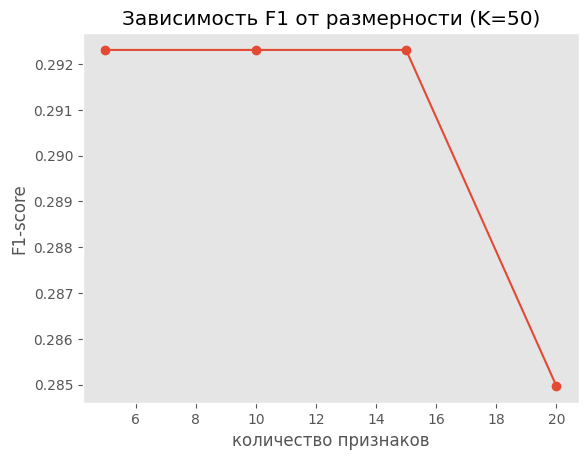

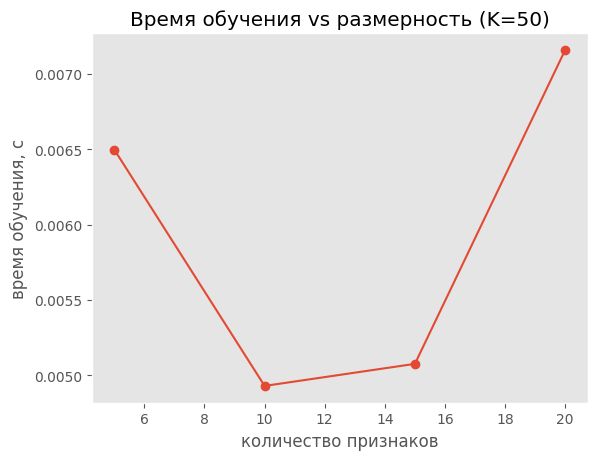

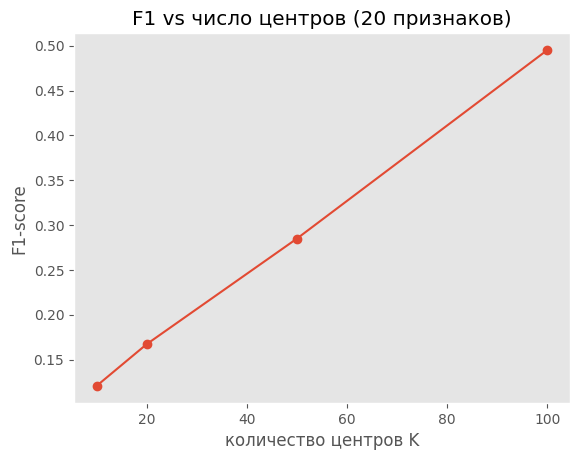

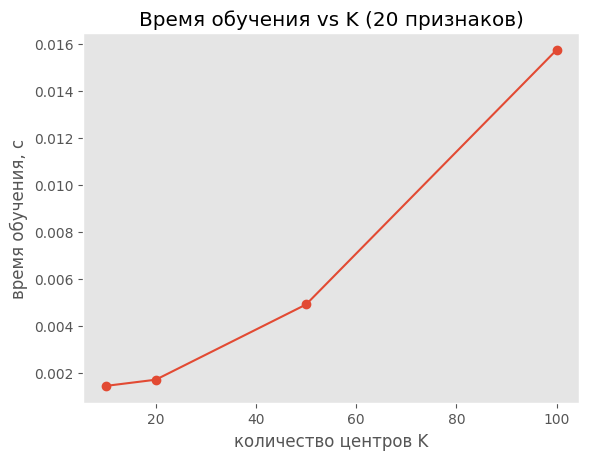

In [110]:

plt.figure()
plt.plot(dim_df['dim'], dim_df['f1'], marker='o')
plt.xlabel('количество признаков')
plt.ylabel('F1‑score')
plt.title('Зависимость F1 от размерности (K=50)')
plt.grid()
plt.show()

plt.figure()
plt.plot(dim_df['dim'], dim_df['time'], marker='o')
plt.xlabel('количество признаков')
plt.ylabel('время обучения, с')
plt.title('Время обучения vs размерность (K=50)')
plt.grid()
plt.show()


plt.figure()
plt.plot(k_df['K'], k_df['f1'], marker='o')
plt.xlabel('количество центров K')
plt.ylabel('F1‑score')
plt.title('F1 vs число центров (20 признаков)')
plt.grid()
plt.show()

plt.figure()
plt.plot(k_df['K'], k_df['time'], marker='o')
plt.xlabel('количество центров K')
plt.ylabel('время обучения, с')
plt.title('Время обучения vs K (20 признаков)')
plt.grid()
plt.show()

In [111]:
best_dim = dim_df.loc[dim_df['f1'].idxmax(), 'dim']
best_K   = k_df.loc[k_df['f1'].idxmax(), 'K']

print('--- РЕЗЮМЕ ---')
print(dim_df)
print()
print(k_df)
print('\nЛучший F1 по размерности достигнут при D =', best_dim)
print('Лучший F1 по числу центров при K =', best_K)

--- РЕЗЮМЕ ---
   dim      time       acc  prec       rec        f1
0    5  0.006498  0.511504   0.5  0.206522  0.292308
1   10  0.004929  0.511504   0.5  0.206522  0.292308
2   15  0.005076  0.511504   0.5  0.206522  0.292308
3   20  0.007160  0.511504   0.5  0.199275  0.284974

     K      time       acc      prec       rec        f1
0   10  0.001435  0.509735  0.487179  0.068841  0.120635
1   20  0.001700  0.523894  0.574468  0.097826  0.167183
2   50  0.004900  0.511504  0.500000  0.199275  0.284974
3  100  0.015731  0.520354  0.509579  0.481884  0.495345

Лучший F1 по размерности достигнут при D = 5
Лучший F1 по числу центров при K = 100


# 4. Оптимизировать структуру и параметры RBF-сетей для повышения точности и масштабируемости. 

In [112]:
def init_centers_mbkm(X_tensor, K, batch_size=1024, iters=100):
    mbkm = MiniBatchKMeans(n_clusters=K, batch_size=batch_size,
                           max_iter=iters, n_init='auto', random_state=2005)
    mbkm.fit(X_tensor.cpu())
    return torch.tensor(mbkm.cluster_centers_, dtype=torch.float32, device=DEVICE)

def nearest_sigma_kdtree(centers):
    tree = KDTree(centers.cpu())
    dists, _ = tree.query(centers.cpu(), k=2)
    sigmas = torch.tensor(dists[:, 1], dtype=torch.float32, device=DEVICE)
    return sigmas


In [113]:
def pinv_randomized(Phi, y, n_components=100):
    U, S, Vt = randomized_svd(Phi, n_components=min(n_components, Phi.shape[1]),
                              random_state=2005)
    S_inv = np.diag(1 / S)
    pseudo = Vt.T @ S_inv @ U.T 
    return pseudo @ y

In [114]:
class HybridRBF(nn.Module):
    def __init__(self, centers, sigmas,
                 hidden_sizes=(64, 32),
                 activation=nn.ReLU,
                 dropout=0.0):
        super().__init__()
        self.rbf = RBFLayer(centers, sigmas, 'gaussian')
        layers = []
        in_dim = centers.size(0)
        for h in hidden_sizes:
            layers += [nn.Linear(in_dim, h), activation()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(self.rbf(x))

def train_hybrid(model, Xtr, ytr, Xva, yva,
                 epochs=60, lr=1e-3, batch=256, l2=1e-4):
    loader = torch.utils.data.DataLoader(
        TensorDataset(Xtr, ytr), batch_size=batch, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    loss_fn = nn.BCEWithLogitsLoss()
    best_f1, best_state = 0, None
    for _ in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            loss_fn(model(xb), yb).backward()
            opt.step()
        with torch.no_grad():
            f1 = evaluate_f1(model, Xva, yva)
            if f1 > best_f1:
                best_f1, best_state = f1, model.state_dict()
    model.load_state_dict(best_state)
    return best_f1

def evaluate_f1(model, X, y):
    y_hat = (torch.sigmoid(model(X)) > 0.5).int().cpu().numpy().ravel()
    y_true = y.cpu().int().numpy().ravel()
    return precision_recall_fscore_support(
        y_true, y_hat, average='binary', zero_division=0)[2]

In [115]:
param_space = {
    'K':            [30, 50, 80, 100, 150, 200],
    'hidden_sizes': [(64,), (128, 32), (64, 32), (128, 64), (64, 64), (128, 128), (64, 128)],
    'lr':           [1e-3, 3e-4],
    'dropout':      [0.0, 0.1, 0.2],
}

def sample_params(space, n_iter=10):
    for comb in ParameterSampler(space, n_iter=n_iter, random_state=2005):
        yield comb

best_cfg, best_f1 = None, -1
for cfg in sample_params(param_space, n_iter=8):
    C = init_centers_mbkm(X_train_t, cfg['K'])
    S = nearest_sigma_kdtree(C)
    model = HybridRBF(C, S,
                      hidden_sizes=cfg['hidden_sizes'],
                      dropout=cfg['dropout']).to(DEVICE)
    f1 = train_hybrid(model, X_train_t, y_train_t,
                      X_val_t, y_val_t,
                      lr=cfg['lr'])
    print(cfg, '→ F1=', round(f1, 3))
    if f1 > best_f1:
        best_f1, best_cfg = f1, (cfg, model.state_dict())

print('\nBest config:', best_cfg[0], 'with F1=', round(best_f1, 3))


{'lr': 0.001, 'hidden_sizes': (64, 32), 'dropout': 0.0, 'K': 30} → F1= 0.582
{'lr': 0.0003, 'hidden_sizes': (128, 64), 'dropout': 0.2, 'K': 50} → F1= 0.659
{'lr': 0.0003, 'hidden_sizes': (64, 128), 'dropout': 0.1, 'K': 200} → F1= 0.656
{'lr': 0.0003, 'hidden_sizes': (64, 32), 'dropout': 0.2, 'K': 150} → F1= 0.656
{'lr': 0.0003, 'hidden_sizes': (128, 128), 'dropout': 0.1, 'K': 200} → F1= 0.519
{'lr': 0.001, 'hidden_sizes': (128, 32), 'dropout': 0.0, 'K': 30} → F1= 0.563
{'lr': 0.0003, 'hidden_sizes': (64, 32), 'dropout': 0.1, 'K': 30} → F1= 0.659
{'lr': 0.0003, 'hidden_sizes': (64, 32), 'dropout': 0.2, 'K': 30} → F1= 0.454

Best config: {'lr': 0.0003, 'hidden_sizes': (64, 32), 'dropout': 0.1, 'K': 30} with F1= 0.659


In [116]:
def bagging_rbf(n_estimators=5, sample_frac=0.7, K=50):
    votes = []
    for i in range(n_estimators):
        idx = rng.choice(len(X_train_t), size=int(sample_frac*len(X_train_t)),
                         replace=True)
        Xb, yb = X_train_t[idx], y_train_t[idx]
        C = init_centers_mbkm(Xb, K)
        S = nearest_sigma_kdtree(C)
        mdl = RBFNetwork(C, S).to(DEVICE)
        mdl.fit_pinv(Xb, yb)
        votes.append(mdl)
    # агрегатор
    def predict(X):
        with torch.no_grad():
            probs = [torch.sigmoid(m(X)) for m in votes]
        return (torch.stack(probs).mean(0) > 0.5).int()
    return predict

bagger = bagging_rbf(n_estimators=7, K=50)
with torch.no_grad():
    y_pred = bagger(X_val_t).cpu().numpy().ravel()
    y_true = y_val_t.cpu().int().numpy().ravel()
f1_bag = precision_recall_fscore_support(y_true, y_pred,
                                         average='binary', zero_division=0)[2]
print('Bagging F1=', round(f1_bag, 3))


Bagging F1= 0.656


In [117]:
Xtr_np = X_train_t.numpy();  Xva_np = X_val_t.numpy()
ytr_np = y_train_t.numpy().ravel();  yva_np = y_val_t.numpy().ravel()

models = {
    'LogReg' : LogisticRegression(max_iter=200),
    'SVM'    : SVC(kernel='rbf', probability=True),
    'RF'     : RandomForestClassifier(n_estimators=200, max_depth=None),
    'GB'     : GradientBoostingClassifier()
}

for name, mdl in models.items():
    mdl.fit(Xtr_np, ytr_np)
    y_pred = mdl.predict(Xva_np)
    f1 = precision_recall_fscore_support(yva_np, y_pred,
                                         average='binary', zero_division=0)[2]
    print(f'{name:6s}  F1={f1:.3f}')

LogReg  F1=0.000
SVM     F1=0.000
RF      F1=0.987
GB      F1=0.995


In [118]:
cfg, state = best_cfg
X_full = torch.cat([X_train_t, X_val_t]);  y_full = torch.cat([y_train_t, y_val_t])

C = init_centers_mbkm(X_full, cfg['K'])
S = nearest_sigma_kdtree(C)
final_model = HybridRBF(C, S,
                        hidden_sizes=cfg['hidden_sizes'],
                        dropout=cfg['dropout']).to(DEVICE)
final_model.load_state_dict(state)

train_hybrid(final_model, X_full, y_full, X_full, y_full,
             epochs=20, lr=cfg['lr'])

with torch.no_grad():
    y_pred = (torch.sigmoid(final_model(X_test_t)) > 0.5).int().cpu().numpy().ravel()
    y_true = y_test_t.cpu().int().numpy().ravel()

acc, prec, rec, f1, _ = accuracy_score(y_true, y_pred), *precision_recall_fscore_support(
    y_true, y_pred, average='binary', zero_division=0)

print(f'\nTEST(Hybrid best) → acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}')


TEST(Hybrid best) → acc=0.483  prec=0.471  rec=0.440  f1=0.455
